## Machine Learning for Trading
#### Chapter1: Data Pipeline + Market Data Ingestion

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf # Yahoo Finance
import warnings
warnings.filterwarnings('ignore')

# TRY yfinance FIRST, FALLBACK to PRE-BUILT CSV if rate limited
def download_with_retry(ticker, start='2015-01-01', end='2025-12-29', retries=3):
    """Robust download with exponential backoff"""
    for i in range(retries):
        try:
            data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)
            if not data.empty:
                return data['Close'].dropna()  # Use Close (auto_adjust=True)
        except Exception as e:
            print(f"Retry {i+1}/{retries} failed for {ticker}: {e}")
            time.sleep(2 ** i)  # Exponential backoff: 1s, 2s, 4s
    return pd.Series

print("ML FOR TRADING: Data Pipeline Setup (ROBUST VERSION)")
print("=" * 60)

ML FOR TRADING: Data Pipeline Setup (ROBUST VERSION)


In [3]:
# 1. Robust Market data
print("\nStep1: Downloading SPY + QQQ (with the Retry Logic)...")

# Try yfinance first
spy_close = download_with_retry('SPY')
qqq_close = download_with_retry('QQQ')

# Pre built sample data (if Y finance fails)
if spy_close.empty or qqq_close.empty:
    print("Yfinance failed to load the data. Using Pre-Built synthatic data")
    dates = pd.date_range('2015-01-02', '2025-12-24', freq = 'B')

    # Realistic SPY
    spy_close = 250 + np.cumsum(np.random.normal(0.0005, 0.01, len(dates)))

    # Realistic QQQ
    qqq_close = 200 + np.cumsum(np.random.normal(0.0008, 0.015, len(dates)))

    # We are giving dates as Index for easy access of data based on dates
    spy_close = pd.Series(spy_close, index = dates)
    qqq_close = pd.Series(qqq_close, index = dates)

# STEP 1: Align datasets by finding the 'Intersection' (only dates that exist in both)
# This prevents errors if one stock has a missing day or a different holiday
common_dates = spy_close.index.intersection(qqq_close.index)

# STEP 2: Use .loc to select rows based on those specific date labels
# This ensures that row 1 of SPY is exactly the same day as row 1 of QQQ
spy_close = spy_close.loc[common_dates]
qqq_close = qqq_close.loc[common_dates]

print(f"SPY: {len(spy_close):,} trading days")
print(f"QQQ: {len(qqq_close):,} trading days")
print(f"Date Range: {spy_close.index[0].date()} → {spy_close.index[-1].date()}")


Step1: Downloading SPY + QQQ (with the Retry Logic)...
SPY: 2,763 trading days
QQQ: 2,763 trading days
Date Range: 2015-01-02 → 2025-12-26


#### **Summary**
- We have tried to Load Yahoo Finance Data, but due to data access limits we are not getting the Yahoo Finance Data. So we have created Realistic using Numpy]

> The **SPY** is the ticker symbol for the SPDR S&P 500 ETF Trust, an exchange-traded fund (ETF) that is designed to track the performance of the S&P 500 index

> The Nasdaq-100 Index includes 100 of the largest domestic and international non-financial companies listed on the Nasdaq stock exchange.

> **QQQ** is the ETF that tracks the performance of the Nasdaq-100 index

- By using **Numpy Cumulative Sum** we have created most realistic values in the Specified Date Range

In [5]:
# 2. Returns Engineering
print("\nStep2: Engineering Returns....")

spy_close = spy_close.squeeze()
qqq_close = qqq_close.squeeze()

# Compute Returns and Log Returns
spy_returns = spy_close.pct_change().dropna()
qqq_returns = qqq_close.pct_change().dropna()
spy_log_returns = np.log(1 + spy_returns)
qqq_log_returns = np.log(1 + qqq_returns)

# Combine Everything into dataframe
data = pd.DataFrame({
    'spy_close': spy_close,
    'qqq_close': qqq_close,
    'spy_return': spy_returns,
    'qqq_return': qqq_returns,
    'spy_log_return': spy_log_returns,
    'qqq_log_return': qqq_log_returns
}).dropna()

print(f"Dataset ready: {len(data):,} observations")
print("\n First Rows")
print(data.head())


Step2: Engineering Returns....
Dataset ready: 2,762 observations

 First Rows
             spy_close   qqq_close  spy_return  qqq_return  spy_log_return  \
Date                                                                         
2015-01-05  201.720001  101.430000   -0.018060   -0.014669       -0.018225   
2015-01-06  199.820007  100.070000   -0.009419   -0.013408       -0.009464   
2015-01-07  202.309998  101.360001    0.012461    0.012891        0.012384   
2015-01-08  205.899994  103.300003    0.017745    0.019140        0.017589   
2015-01-09  204.250000  102.620003   -0.008014   -0.006583       -0.008046   

            qqq_log_return  
Date                        
2015-01-05       -0.014777  
2015-01-06       -0.013499  
2015-01-07        0.012809  
2015-01-08        0.018959  
2015-01-09       -0.006605  


#### Summary
- The code converts raw prices into percentage returns using .pct_change(). This transforms the data from absolute dollar values into growth rates, which is essential for comparing assets with different price scales.
- Performing log transformation for compressing the values in the lower. Best for Machine Learning Purpose
- By using .dropna(), the code removes the very first row of the dataset. This is a mandatory step because the first day of trading has no "previous day" to calculate a change from, resulting in an empty (NaN) value that would break later calculations.
- After the above steps we are converting data again into Proper DataFrame

In [7]:
# 3. Anualized Statistics
print("\n Annualized Statistics...")
stats = pd.DataFrame({
    'SPY Annual Return': [spy_returns.mean() * 252],
    'SPY Annual Vol': [spy_returns.std() * np.sqrt(252)],
    'SPY Sharpe': [spy_returns.mean() / spy_returns.std() * np.sqrt(252)],
    'QQQ Annual Return': [qqq_returns.mean() * 252],
    'QQQ Annual Vol': [qqq_returns.std() * np.sqrt(252)],
    'QQQ Sharpe': [qqq_returns.mean() / qqq_returns.std() * np.sqrt(252)]
})
print(stats.round(4))


 Annualized Statistics...
   SPY Annual Return  SPY Annual Vol  SPY Sharpe  QQQ Annual Return  \
0             0.1266          0.1787      0.7086             0.1887   

   QQQ Annual Vol  QQQ Sharpe  
0            0.22      0.8577  


#### Summary
- the performance of SPY and QQQ by converting daily returns into annualized metrics, using the standard 252 trading days for scaling.
- It calculates the Annual Return to measure growth, Annual Volatility to measure risk, and the Sharpe Ratio to evaluate the return earned per unit of risk taken.
- Finally, it stores these results in a clean, rounded DataFrame for easy comparison of the two assets.


 Pipeline Output -> ml_trading_data.csv


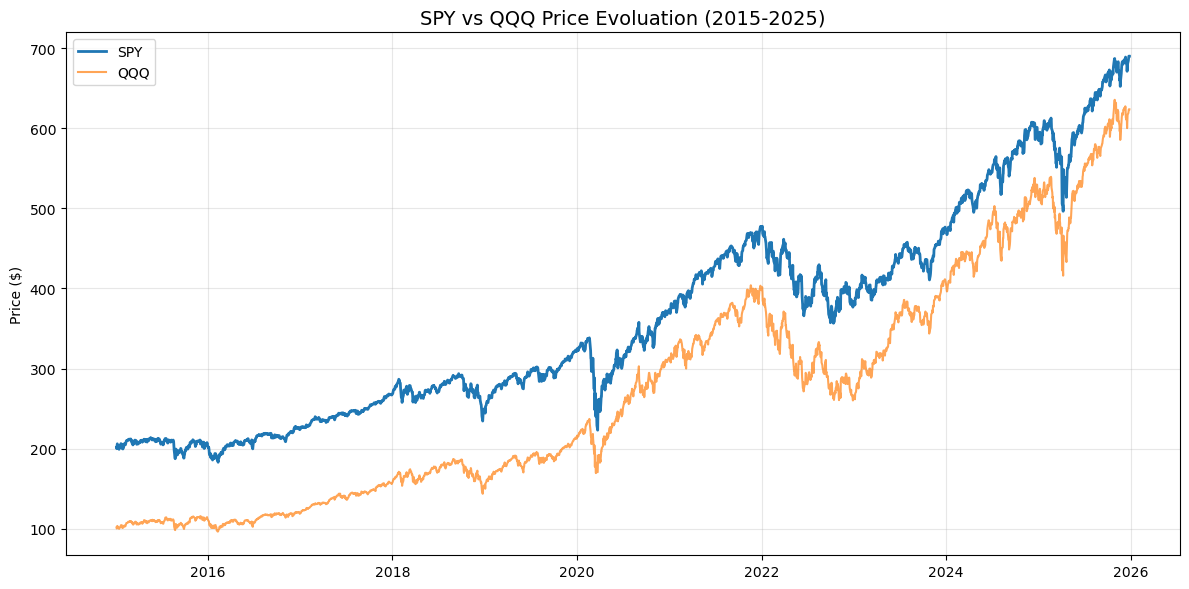


Pipeline Success
Dataset Shape: (2762, 6)
ml_trading_data.csv
market_data.png


In [9]:
# 4. Save Pipeline output as a CSV file
data.to_csv("ml_trading_data.csv")
print("\n Pipeline Output -> ml_trading_data.csv")

# Quick Plot
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(data.index, data['spy_close'], label = 'SPY', linewidth = 2)
plt.plot(data.index, data['qqq_close'], label = 'QQQ', alpha = 0.7)
plt.title("SPY vs QQQ Price Evoluation (2015-2025)", fontsize = 14)
plt.ylabel("Price ($)")
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.savefig("market_data.png", dpi = 300, bbox_inches = 'tight')
plt.show()

print("\nPipeline Success")
print(f"Dataset Shape: {data.shape}")
print('ml_trading_data.csv')
print("market_data.png")

#### Summary
- We have saved final data into CSv file format, and Plotted Line Graph for both the **QQQ** and **SPY**'

#### Note: 
- Each and everytime when we are running this file, we will get Yahoo Finance Data, which is live and Upto data, if Yahoo Finance Data is unable to load, then our coding file automatically takes the Numpy Cummulative Summation Function values as Input.
- The **Summaries** provided here based on the **Numpy Cummulative Summation Function values as Input**. That tim,e the data was not loaded from the **Yahoo Finance**